## Import libraries

In [3]:
import scanpy as sc
import anndata as an
import numpy as np
from math import sqrt

## Load data

In [4]:
def LoadData(path):
    adata = sc.read_visium(path)
    adata.var_names_make_unique()
    return adata

In [5]:
path ="/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/human_breast_cancer_ST_data"

In [6]:
adata = LoadData(path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [76]:
adata.n_obs

3798

In [8]:
adata.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1',
       'AAACCCGAACGAAATC-1', 'AAACCGGGTAGGTACC-1', 'AAACCTAAGCAGCCGG-1',
       'AAACCTCATGAAGTTG-1',
       ...
       'TTGTGGTAGGAGGGAT-1', 'TTGTGGTGGTACTAAG-1', 'TTGTGTATGCCACCAA-1',
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1',
       'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3798)

Why do the observables have those names? They look like DNA molecules. The observables are the spots, right?

## Calculate distances

In [9]:
def euclidean_distance(spot1, spot2):
    distance = 0
    for i in range(2):
        distance += (spot1[i] - spot2[i]) ** 2
    return sqrt(distance)

## Make some test data

In [10]:
testdata = np.array([[17428, 15937],
         [6092, 18054],
         [16351, 7383],
                     [7593, 18294],
                    [7190, 14730],
                    [10484, 5709]])

In [11]:
testdata2 = np.array([[10, 10],
                     [5, 15],
                     [20, 20],
                     [2, 4],
                     [50, 60],
                     [100, 90]])

In [12]:
spot1 = testdata2[0]

### Test euclidean distance function

In [13]:
for spot in testdata2:
    distance = euclidean_distance(spot1, spot)
    print(distance)

0.0
7.0710678118654755
14.142135623730951
10.0
64.03124237432849
120.41594578792295


# Calculate KNN by brute force

### For one spot

In [14]:
def get_neighbours(data, spot1, k, eps = 300):
    distances = []
    for spot in data:
        dist = euclidean_distance(spot1, spot)
        distances.append((spot, dist))
    distances.sort(key=lambda tup: tup[1])
    k_sel = min(k, sum([y < eps for x,y in distances]))
    neighbours = []
    for i in range(k_sel+1):
        neighbours.append(distances[i][0])
    return neighbours

In [15]:
adata.uns['spatial']['V1_Breast_Cancer_Block_A_Section_1']['scalefactors']['spot_diameter_fullres']

177.48170171293427

The function returns a list of arrays where the first one is the spot and the following are the neighbours.

In [16]:
one_spot = get_neighbours(testdata2, spot1, 2)

In [17]:
one_spot

[array([10, 10]), array([ 5, 15]), array([2, 4])]

### For all spots

In [18]:
def get_all_neighbours(data, k):
    neighbours = []
    for spot in data:
        neighbours.append(get_neighbours(data, spot, k))
    neighbours = np.array(neighbours, dtype=object)
    return neighbours

### Try on ST data

In [19]:
crd = adata.obsm['spatial']

In [20]:
crd[1]

array([ 6092, 18054])

In [21]:
%time
KNN = get_all_neighbours(crd, 6)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [22]:
KNN.shape

(3798,)

In [23]:
adata.obsm['KNN'] = KNN

In [24]:
adata.obsm['KNN']

array([list([array([17428, 15937]), array([17701, 15937]), array([17155, 15936]), array([17291, 16174]), array([17565, 15700]), array([17564, 16175]), array([17291, 15699])]),
       list([array([ 6092, 18054]), array([ 5819, 18054]), array([ 6365, 18055]), array([ 5955, 18291]), array([ 6229, 17817]), array([ 6228, 18292]), array([ 5956, 17816])]),
       list([array([16351,  7383]), array([16624,  7383]), array([16078,  7382]), array([16488,  7146]), array([16214,  7620]), array([16487,  7621]), array([16215,  7145])]),
       ...,
       list([array([ 7593, 18294]), array([ 7320, 18294]), array([ 7457, 18057]), array([ 7730, 18057]), array([ 7867, 18295]), array([ 7457, 18532]), array([ 7730, 18532])]),
       list([array([ 7190, 14730]), array([ 6917, 14730]), array([ 7463, 14731]), array([ 7054, 14493]), array([ 7327, 14493]), array([ 7327, 14968]), array([ 7053, 14968])]),
       list([array([10484,  5709]), array([10757,  5710]), array([10620,  5472]), array([10347,  5472]), arr

In [25]:
KNN[sel_id,:,:]

NameError: name 'sel_id' is not defined

In [ ]:
sel_id

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

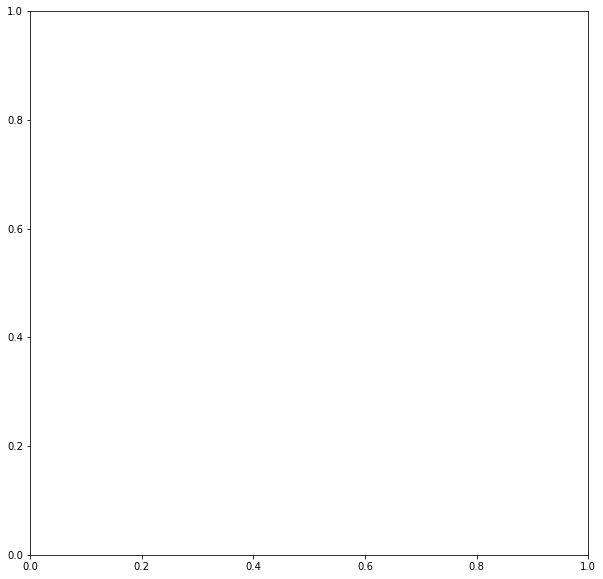

In [26]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize = (10,10))

sel_id = 4
ax.scatter(KNN[sel_id,:,0], KNN[sel_id,:,1], s= 100, c = "red")
ax.scatter(KNN[sel_id,0,0], KNN[sel_id,0,1],s = 200, c = "none", edgecolor = "blue")
ax.set_aspect("auto")

plt.show()

# Calculate KNN using a kd tree

## Using scipy

In [27]:
from scipy.spatial import KDTree

In [28]:
help(KDTree)

Help on class KDTree in module scipy.spatial.kdtree:

class KDTree(scipy.spatial.ckdtree.cKDTree)
 |  KDTree(data, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
 |  
 |  kd-tree for quick nearest-neighbor lookup
 |  
 |  This class provides an index into a set of k-dimensional points
 |  which can be used to rapidly look up the nearest neighbors of any
 |  point.
 |  
 |  Parameters
 |  ----------
 |  data : array_like, shape (n,m)
 |      The n data points of dimension m to be indexed. This array is
 |      not copied unless this is necessary to produce a contiguous
 |      array of doubles, and so modifying this data will result in
 |      bogus results. The data are also copied if the kd-tree is built
 |      with copy_data=True.
 |  leafsize : positive int, optional
 |      The number of points at which the algorithm switches over to
 |      brute-force.  Default: 10.
 |  compact_nodes : bool, optional
 |      If True, the kd-tree is built to s

In [29]:
kd = KDTree(adata.obsm["spatial"])

In [30]:
dist,indx = kd.query(adata.obsm["spatial"],k=6)

In [31]:
indx

array([[   0,  397, 1087,  487, 2195, 2425],
       [   1,  588, 2367, 1773, 3464, 3165],
       [   2, 3749, 2157, 3107, 3105, 1092],
       ...,
       [3795, 3021, 1945,   67, 3427,  301],
       [3796,  585, 2740, 2952, 2039, 3573],
       [3797, 1621, 2399, 2614,  118, 3563]])

In [32]:
adata.obs_names[0]

'AAACAAGTATCTCCCA-1'

In [33]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'KNN'

In [34]:
def KNN_indx_to_barcode(indx):
    KNN_ids = []
    index = 0
    for i in indx:
        KNN_ids.append([])
        for j in i:
            KNN_ids[index].append(adata.obs_names[j])
        KNN_ids[index] = np.array(KNN_ids[index])
        index += 1
    return np.array(KNN_ids)

In [35]:
KNN_ids = KNN_indx_to_barcode(indx)

In [36]:
KNN_ids

array([['AAACAAGTATCTCCCA-1', 'ACTAGTTGCGATCGTC-1', 'CAGCAGTCCAGACTAT-1',
        'AGAGGCTTCGGAAACC-1', 'GCATCGGCCGTGTAGG-1', 'GGCAGCAAACCTATGC-1'],
       ['AAACACCAATAACTGC-1', 'AGGCGGTTTGTCCCGC-1', 'GGAACCTTGACTCTGC-1',
        'CTCGTCGAGGGCTCAT-1', 'TGGACGCAATCCAGCC-1', 'TCCCTGGCGTATTAAC-1'],
       ['AAACAGAGCGACTCCT-1', 'TTGCGTGAACGCTTAG-1', 'GCAACCACCAGACCGG-1',
        'TCACTCGTGCAACGGC-1', 'TCACTACGACCAATGC-1', 'CAGCCTCTCCTCAAGA-1'],
       ...,
       ['TTGTTTCATTAGTCTA-1', 'TATATATCGAGAAATG-1', 'GAAGAAACGATATTGT-1',
        'AACAGCTGTGTGGCAA-1', 'TGCGACGGCCGAACGT-1', 'ACCCGAGCGAAATTAC-1'],
       ['TTGTTTCCATACAACT-1', 'AGGCCCTAGAACGCCA-1', 'GTGGACCAACCCGATT-1',
        'TAGAGATCATGCAACT-1', 'GAGAGGTGCATTCTGG-1', 'TTAACTTCAGGTAGGA-1'],
       ['TTGTTTGTGTAAATTC-1', 'CGTAGCGCCGACGTTG-1', 'GGATCAAAGGACGAGG-1',
        'GTAGCGCTGTTGTAGT-1', 'AACTGGTGTGGGCCTT-1', 'TTAAACCGGTAGCGAC-1']],
      dtype='<U18')

In [37]:
adata.obsm['KNN_ids'] = KNN_ids

In [38]:
adata.obsm['KNN_ids']

array([['AAACAAGTATCTCCCA-1', 'ACTAGTTGCGATCGTC-1', 'CAGCAGTCCAGACTAT-1',
        'AGAGGCTTCGGAAACC-1', 'GCATCGGCCGTGTAGG-1', 'GGCAGCAAACCTATGC-1'],
       ['AAACACCAATAACTGC-1', 'AGGCGGTTTGTCCCGC-1', 'GGAACCTTGACTCTGC-1',
        'CTCGTCGAGGGCTCAT-1', 'TGGACGCAATCCAGCC-1', 'TCCCTGGCGTATTAAC-1'],
       ['AAACAGAGCGACTCCT-1', 'TTGCGTGAACGCTTAG-1', 'GCAACCACCAGACCGG-1',
        'TCACTCGTGCAACGGC-1', 'TCACTACGACCAATGC-1', 'CAGCCTCTCCTCAAGA-1'],
       ...,
       ['TTGTTTCATTAGTCTA-1', 'TATATATCGAGAAATG-1', 'GAAGAAACGATATTGT-1',
        'AACAGCTGTGTGGCAA-1', 'TGCGACGGCCGAACGT-1', 'ACCCGAGCGAAATTAC-1'],
       ['TTGTTTCCATACAACT-1', 'AGGCCCTAGAACGCCA-1', 'GTGGACCAACCCGATT-1',
        'TAGAGATCATGCAACT-1', 'GAGAGGTGCATTCTGG-1', 'TTAACTTCAGGTAGGA-1'],
       ['TTGTTTGTGTAAATTC-1', 'CGTAGCGCCGACGTTG-1', 'GGATCAAAGGACGAGG-1',
        'GTAGCGCTGTTGTAGT-1', 'AACTGGTGTGGGCCTT-1', 'TTAAACCGGTAGCGAC-1']],
      dtype='<U18')

How do I plot this now...

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

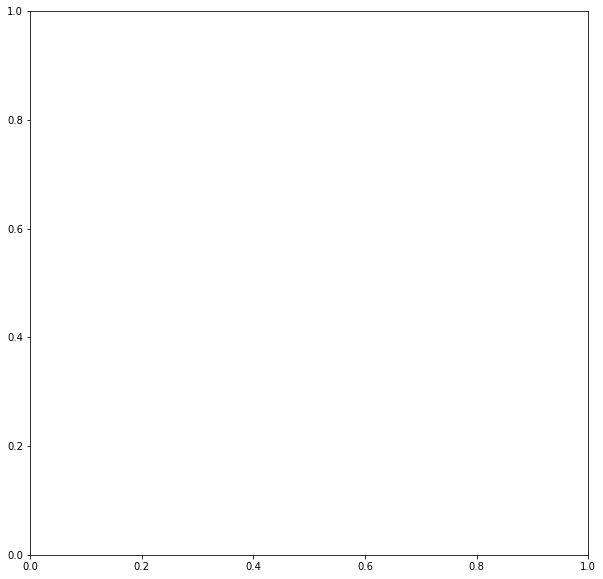

In [39]:
fig,ax = plt.subplots(1,1, figsize = (10,10))

sel_id = 4
ax.scatter(KNN_ids[sel_id,:,0], KNN_ids[sel_id,:,1], s= 100, c = "red")
ax.scatter(KNN_ids[sel_id,0,0], KNN_ids[sel_id,0,1],s = 200, c = "none", edgecolor = "blue")
ax.set_aspect("auto")

plt.show()

### Set a distance limit to neighbours

In [40]:
eps = 300

In [41]:
dist

array([[  0.        , 273.        , 273.0018315 , 273.74805935,
        273.74805935, 274.11676344],
       [  0.        , 273.        , 273.0018315 , 273.74805935,
        273.74805935, 274.11676344],
       [  0.        , 273.        , 273.0018315 , 273.74805935,
        273.74805935, 274.11676344],
       ...,
       [  0.        , 273.        , 273.24897072, 273.74805935,
        274.00182481, 274.11676344],
       [  0.        , 273.        , 273.0018315 , 273.24897072,
        273.74805935, 274.61427494],
       [  0.        , 273.0018315 , 273.24897072, 273.74805935,
        274.        , 274.11676344]])

In [42]:
def remove_long_distances(dist):
    for array in dist:
        array = array[array < eps]
        print(array)

In [43]:
remove_long_distances(dist)

[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         274.11676344 274.61427494]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.61427494]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.74805935 274.11676344]
[

[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.61427494]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         2

[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 273.74805935
 274.11676344]
[  0.         273.         273.0018315  273.74805935 274.11676344
 274.11676344]
[  0.         273.         273.0018315  273.24897072 273.74805935
 274.11676344]
[  0.         273.         2

In [44]:
def remove_false_neighbours(dist, indx, eps = 300):
    dist_sel = []
    indx_sel = []
    for i in range(len(dist)):
        dist_sel.append([])
        indx_sel.append([])
        for j in range(len(dist[i])):
            if dist[i][j] < eps:
                dist_sel[i].append(dist[i][j])
                indx_sel[i].append(indx[i][j])
        dist_sel[i] = np.array(dist_sel[i])
        indx_sel[i] = np.array(indx_sel[i])
    return np.array(dist_sel, dtype=object), np.array(indx_sel, dtype=object)

In [73]:
dist_sel, indx_sel = remove_false_neighbours(dist, indx)

In [74]:
dist_sel

array([array([  0.        , 273.        , 273.0018315 , 273.74805935,
       273.74805935, 274.11676344]),
       array([  0.        , 273.        , 273.0018315 , 273.74805935,
       273.74805935, 274.11676344]),
       array([  0.        , 273.        , 273.0018315 , 273.74805935,
       273.74805935, 274.11676344]),
       ...,
       array([  0.        , 273.        , 273.24897072, 273.74805935,
       274.00182481, 274.11676344]),
       array([  0.        , 273.        , 273.0018315 , 273.24897072,
       273.74805935, 274.61427494]),
       array([  0.        , 273.0018315 , 273.24897072, 273.74805935,
       274.        , 274.11676344])], dtype=object)

In [47]:
indx_sel

array([array([   0,  397, 1087,  487, 2195, 2425]),
       array([   1,  588, 2367, 1773, 3464, 3165]),
       array([   2, 3749, 2157, 3107, 3105, 1092]), ...,
       array([3795, 3021, 1945,   67, 3427,  301]),
       array([3796,  585, 2740, 2952, 2039, 3573]),
       array([3797, 1621, 2399, 2614,  118, 3563])], dtype=object)

In [75]:
dist_sel[4]

array([  0.        , 273.        , 274.11676344, 274.61427494])

## Code from scratch

### Build the tree

In [51]:
def build_kdtree(crd, depth=0):
    n = len(crd)
    
    if n <= 0:
        return None
    
    axis = depth % 2
    sorted_spots = sorted(crd, key=lambda crd: crd[axis])
    return{
        'root': sorted_spots[n // 2],
        'left': build_kdtree(sorted_spots[:n // 2], depth + 1),
        'right': build_kdtree(sorted_spots[n // 2 + 1:], depth + 1)
    }

In [52]:
kdtree = build_kdtree(crd)

In [53]:
kdtree

{'root': array([12779, 19729]),
 'left': {'root': array([ 5965, 13065]),
  'left': {'root': array([9117, 6657]),
   'left': {'root': array([7884, 8793]),
    'left': {'root': array([7069, 6416]),
     'left': {'root': array([6795, 6890]),
      'left': {'root': array([6113, 6652]),
       'left': {'root': array([5295, 6175]),
        'left': {'root': array([5705, 5938]),
         'left': {'root': array([5296, 5700]),
          'left': {'root': array([5433, 5463]),
           'left': {'root': array([5023, 5699]), 'left': None, 'right': None},
           'right': {'root': array([5570, 5225]),
            'left': None,
            'right': None}},
          'right': {'root': array([5432, 5938]),
           'left': {'root': array([5159, 5937]), 'left': None, 'right': None},
           'right': {'root': array([5569, 5700]),
            'left': None,
            'right': None}}},
         'right': {'root': array([5979, 5464]),
          'left': {'root': array([5843, 5226]),
           'left'

### Find which spot out of two is the closer one

In [54]:
def closer_distance(pivot, p1, p2):
    if p1 is None:
        return p2
    if p2 is None:
        return p1
    
    d1 = euclidean_distance(pivot, p1)
    d2 = euclidean_distance(pivot, p2)
    
    if d1 == 0:
        return p2
    elif d2 == 0:
        return p1
    elif d1 < d2:
        return p1
    else:
        return p2

In [55]:
pivot = np.array([15533,  6906])

In [56]:
p1 = np.array([16611, 14510])

In [57]:
p2 = np.array([15258,  7856])

In [58]:
closer_distance(pivot, p1, p2)

array([15258,  7856])

### Find nearest neighbour for one spot

In [62]:
dim = 2

In [63]:
def kdtree_closest_spot(root, spot, depth = 0):
    
    if root is None:
        return None
    
    axis = depth % dim
    next_branch = None
    oppositive_branch = None
    
    if spot[axis] < root['spot'][axis]:
        next_branch = root['left']
        opposite_branch = root['right']
    else:
        next_branch = root['right']
        opposite_branch = root['left']
    
    best = closer_distance(spot,
                          kdtree_closest_spot(next_branch,
                                              spot,
                                              depth + 1),
                          root['spot'])
    
    if euclidean_distance(spot, best) > (spot[axis]) - root['spot'][axis]:
        best = closer_distance(spot,
                              kdtree_closest_spot(opposite_branch,
                                                  spot,
                                                  depth + 1),
                              best)
    return best

In [64]:
pivot

array([15533,  6906])

In [65]:
kdtree_closest_spot(kdtree, pivot)

KeyError: 'spot'

In [66]:
get_neighbours(crd, pivot, 1)

[array([15533,  6906]), array([15260,  6906])]

Both methods give the same nearest neighbour. That's good.

### Find KNN for one spot

In [67]:
neighbours = []

In [68]:
def FindKNN_one_spot(kdtree, spot, k, depth = 0):
    
#    if depth == 0:
#        neighbours = []
    
    neighbours.append(spot)
    
    for i in range(k):
    
        if kdtree is None:
            return None

        axis = depth % dim
        next_branch = None
        oppositive_branch = None

        if spot[axis] < kdtree['spot'][axis]:
            next_branch = kdtree['left']
            opposite_branch = kdtree['right']
        else:
            next_branch = kdtree['right']
            opposite_branch = kdtree['left']

        best = closer_distance(spot,
                              kdtree_closest_spot(next_branch,
                                                  spot,
                                                  depth + 1),
                              kdtree['spot'])

        if euclidean_distance(spot, best) > (spot[axis]) - kdtree['spot'][axis]:
            best = closer_distance(spot,
                                  kdtree_closest_spot(opposite_branch,
                                                      spot,
                                                      depth + 1),
                                   best)
        
        
        neighbours.append(best)
    
    return neighbours

In [69]:
FindKNN_one_spot(kdtree, pivot, 5)

KeyError: 'spot'

The function has a problem anytime you want more than 1 neighbour.

### Find KNN for all spots

In [70]:
def FindKNN(crd, k):
    neighbours = []
    for spot in crd:
        neighbours.append(FindKNN_one_spot(crd, spot, k))
    neighbours = np.array(neighbours)
    return neighbours

In [71]:
FindKNN(crd, 2)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

This is not working yet, and I have not figured out why yet.